In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
%matplotlib inline

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

2.0.0-beta0


original data source: https://www.kaggle.com/kazanova/sentiment140

cleaned data source: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv

In [2]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
training_size = 160000
test_portion = .1

In [3]:
df = pd.read_csv('data/training_cleaned.csv', names=['label', 'id', 'time', 
                                                      'no_query', 'name', 'corpus'])

In [4]:
df.label[df.label==4] = 1
df.tail()

,label,id,time,no_query,name,corpus
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
df.label[1], df.corpus[1]

(0,
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!")

In [8]:
new_df = df.sample(training_size)
new_df.tail()

,label,id,time,no_query,name,corpus
978880,1,1833877177,Mon May 18 00:46:50 PDT 2009,NO_QUERY,StephenRinaldo,Alls well that ends well....healthy and can ha...
547823,0,2202185377,Tue Jun 16 21:22:36 PDT 2009,NO_QUERY,Cristybaby,i wanna crawl in a ball..
663608,0,2244188271,Fri Jun 19 14:25:08 PDT 2009,NO_QUERY,Patchwork__,is feeeelllinggg super tired.
357235,0,2044598179,Fri Jun 05 09:34:49 PDT 2009,NO_QUERY,roxyheartbeaver,@rox74ever you ok? haven't tweeted all day and...
1526657,1,2177066100,Mon Jun 15 05:22:37 PDT 2009,NO_QUERY,graciebabee,@luvtheveronicas hey! you guys have a fantasti...


In [9]:
new_df.label.unique()

array([1, 0], dtype=int64)

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_df.corpus)

word_index = tokenizer.word_index
# depend on how you get the training data, this output maybe different
len(word_index)

138748

In [11]:
sequences = tokenizer.texts_to_sequences(new_df.corpus)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
print(padded.shape)
split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = new_df.label.iloc[:split]
train_labels = new_df.label.iloc[split:]

(160000, 16)


In [12]:
word_index['i']

1

glove pretrained vector: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt

In [13]:
embeddings_index = {}
with open('data/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
        
len(embeddings_matrix)

138749

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim,
                      input_length=max_length, weights=[embeddings_matrix],
                      trainable=False),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                     mode='max',
                                                     patience=3)

num_epochs=50
history = model.fit(training_sequences, train_labels, epochs=num_epochs,
                   validation_data=(test_sequences, test_labels),
                   verbose=2, callbacks=[stop_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13874900  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,940,053
Trainable params: 65,153
Non-trainable params: 13,874,900
_______________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 144000 samples, validate on 16000 samples
Epoch 1/50
144000/144000 - 147s - loss: 0.5664 - accuracy: 0.7007 - val_loss: 0.5250 - val_accuracy: 0.7348
Epoch 2/50
144000/144000 - 149s - loss: 0.5276 - accuracy: 0.7304 - val_loss: 0.5218 - val_accuracy: 0.7393
Epoch 3/50
144000/144000 - 153s - loss: 0.5108 - accuracy: 0.7439 - val_loss: 0.5011 - val_accuracy: 0.7552
Epoch 4/50
144000/144000 - 151s - loss: 0.5002 - accuracy: 0.7513 - val_loss: 0.5020 - val_accuracy: 0.7556
Epoch 5/50
144000/144000 - 152s - loss: 0.4920 - accuracy: 0.7573 - val_loss: 0.5017 - val_accuracy: 0.7494
Epoch 6/50
144000/144000 - 148s - loss: 0.4845 - accuracy: 0.7611 - val_loss: 0.5066 - val_accuracy: 0.7483
Epoch 7/50
144000/144000 - 150s - loss: 0.4788 - accuracy: 0.7651 - val_loss: 0.4994 - val_accuracy: 0.7566
Epoch 8/50
144000/144000 - 152s - loss: 0.4740 - accuracy: 0.7681 - val_loss: 0.4979 - val_accuracy: 0.7545
Epoch 9/50
144000/144000 - 157s - loss: 0.4711 - accuracy: 0.7688 - val_loss: 0.4994 

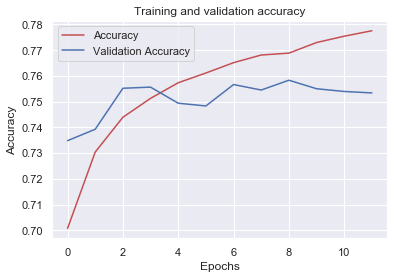

<Figure size 432x288 with 0 Axes>

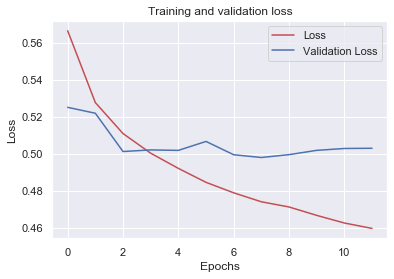

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

# Expected Output
# A chart where the validation loss does not increase sharply!